In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import PIL.Image
import numpy as np
import IPython.display as display
import matplotlib.pyplot as plt

img_size = (409,512)

# Load the pre-trained VGG19 model, this is needed to train the feed forward model
model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
model.trainable = False


# Print the summary of the model
model.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 

In [ ]:
content_image = tf.io.read_file('/content/drive/MyDrive/Colab_Notebooks/Neural_Style_Transfer/NST_pictures/dogs.jpeg')
style_image = tf.io.read_file('/content/drive/MyDrive/Colab_Notebooks/Neural_Style_Transfer/NST_pictures/vgogh.jpeg')

In [ ]:
def image_to_tensor(image):
  image = tf.image.decode_image(image, channels=3)
  image /= 255
  image = tf.image.resize(image, img_size)
  image = tf.expand_dims(image, axis = 0)
  return image

def tensor_to_image(tensor):
  tensor = tf.squeeze(tensor, axis=0)
  tensor = tf.multiply(tensor,255)
  tensor = np.array(tensor, dtype=np.uint8)
  return PIL.Image.fromarray(tensor)


content_image = image_to_tensor(content_image)
print(content_image.shape)
style_image = image_to_tensor(style_image)
print(style_image.shape)
#target = tf.Variable(tf.random.uniform(shape=style_image.shape, minval=0.0, maxval=1.0))
target = tf.Variable(content_image)
print(style_image.shape)

(1, 409, 512, 3)
(1, 409, 512, 3)
(1, 409, 512, 3)


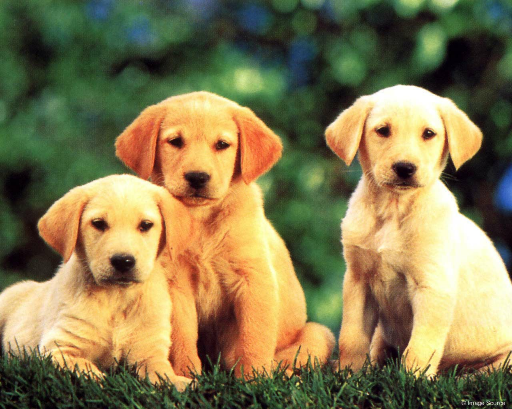

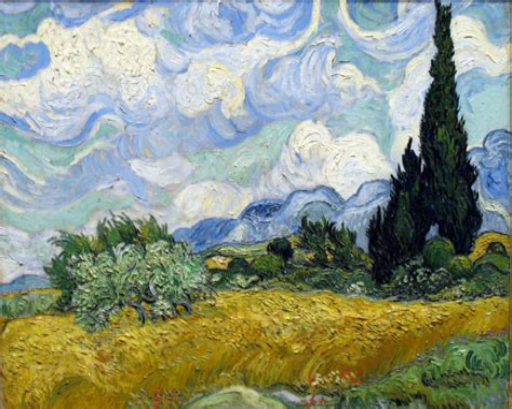

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

display.clear_output(wait=True)
display.display(tensor_to_image(content_image))
display.display(tensor_to_image(style_image))

In [ ]:
def gram_matrix(input_tensor):
    n_channels = input_tensor.get_shape().as_list()[-1]
    unwrapped_out = tf.reshape(input_tensor, [-1, n_channels])
    style_matrix = tf.matmul(unwrapped_out, unwrapped_out, transpose_a=True)
    return style_matrix

In [ ]:
#getting the output of the model
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

outputs = [model.get_layer(layer).output for layer in style_layers + content_layers]
model = tf.keras.Model([model.inputs], outputs)

def extractor(image):
  image = image*255
  preprocessed_image = tf.keras.applications.vgg19.preprocess_input(image)
  output = model(preprocessed_image)
  for i in range(num_style_layers):
    output[i] = gram_matrix(output[i])
  return output

style_output = extractor(style_image)
content_output = extractor(content_image)

for name, shape in zip(style_layers, content_output[:-1]):
  print(name)
  print(shape.shape)

block1_conv1
(64, 64)
block2_conv1
(128, 128)
block3_conv1
(256, 256)
block4_conv1
(512, 512)
block5_conv1
(512, 512)


In [ ]:
style_weight=1e-2
content_weight=1e4
tvl_weight = 30

def total_loss(target_output):

    style_loss = tf.add_n([tf.reduce_mean((target_output[i]-style_output[i])**2) for i in range(num_style_layers)])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.reduce_mean((target_output[num_style_layers]-content_output[num_style_layers])**2)
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

def total_variation_loss(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
  return tf.reduce_sum(tf.abs(x_var)) + tf.reduce_sum(tf.abs(y_var))

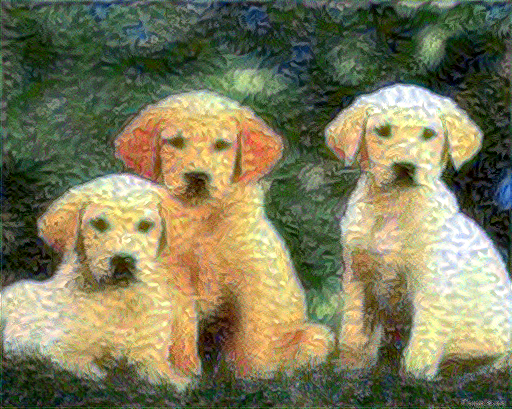

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
epochs = 1
steps = 20

@tf.function()
def train(target):
  with tf.GradientTape() as tape:
      target_output = extractor(target)
      loss = total_loss(target_output)
      loss += total_variation_loss(target)*tvl_weight
  grad = tape.gradient(loss, target)
  optimizer.apply_gradients([(grad, target)])
  target.assign(tf.clip_by_value(target, clip_value_min=0.0, clip_value_max=1.0))

for epoch in range(epochs):
  for step in range(steps):
    train(target)
  display.display(tensor_to_image(target))

For Video:

In [ ]:
import cv2
from google.colab.patches import cv2_imshow


def video_image_to_tensor(image):
  image = tf.cast(image, tf.float32)
  image /= 255
  return tf.expand_dims(image, axis = 0)

def tensor_to_image(tensor, to_numpy = True):
  tensor = tf.squeeze(tensor, axis=0)
  tensor = tf.multiply(tensor,255)
  tensor = np.array(tensor, dtype=np.uint8)
  if to_numpy == False:
    return PIL.Image.fromarray(tensor)
  return tensor

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
stability_loss_weight = 1

class stability_generator:
  def __init__(self):
    self.previous_u = []
    self.previous_v = []

  def get_stability(self, frame, last_frame):
    frame1_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame2_gray = cv2.cvtColor(last_frame, cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(frame1_gray, frame2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    u, v = flow[..., 0], flow[..., 1]

    if len(self.previous_u) == 0:
        self.previous_u = u
        self.previous_v = v

    temporal_gradient_u = u - self.previous_u
    temporal_gradient_v = v - self. previous_v

    magnitudes = np.sqrt(temporal_gradient_u**2 + temporal_gradient_v**2)
    stability_measure = cv2.blur(magnitudes, img_size)

    self.previous_u = u
    self.preivous_v = v
    return stability_measure


def stability_loss(target, last_frame, stability_weights):
    stability_weights = tf.expand_dims(stability_weights, axis = 2)
    loss = tf.reduce_mean((target- last_frame)**2)
    loss = tf.reduce_mean(target * stability_weights)
    return loss


@tf.function()
def train_with_optical_flow(target, last_frame, stability_weights):
  with tf.GradientTape() as tape:
      target_output = extractor(target)
      loss = total_loss(target_output)
      loss += stability_loss(target, last_frame, stability_weights) * stability_loss_weight
  grad = tape.gradient(loss, target)
  optimizer.apply_gradients([(grad, target)])
  target.assign(tf.clip_by_value(target, clip_value_min=0.0, clip_value_max=1.0))

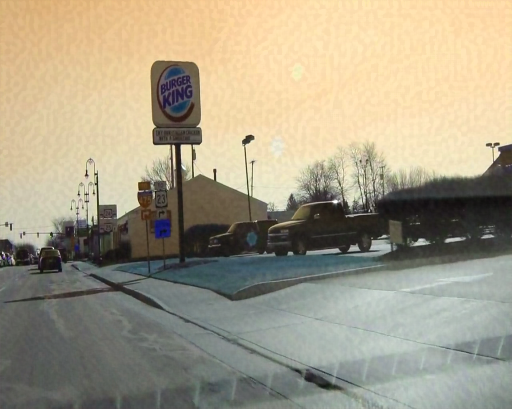

tf.Tensor(
[[1.0022815  1.002277   1.0021149  ... 0.4560146  0.45603457 0.45603234]
 [1.0022815  1.002277   1.0021149  ... 0.4560146  0.45603457 0.45603234]
 [1.00238    1.0023755  1.0022134  ... 0.45603397 0.45605412 0.45605198]
 ...
 [2.0513225  2.0513513  2.0514092  ... 1.9431844  1.9428658  1.9427129 ]
 [2.0515506  2.051579   2.0516348  ... 1.9432195  1.9429018  1.9427491 ]
 [2.0516212  2.0516489  2.051703   ... 1.9431984  1.9428812  1.9427286 ]], shape=(409, 512), dtype=float32)


In [ ]:
steps = 20
cap = cv2.VideoCapture("/content/drive/MyDrive/Colab_Notebooks/Neural_Style_Transfer/NST_pictures/test_ohio.mp4")

W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

output_video = cv2.VideoWriter('/content/drive/MyDrive/Colab_Notebooks/Neural_Style_Transfer/NST_pictures/output_video.mp4', cv2.VideoWriter_fourcc(*'MP4V'), fps, (512, 409))

stability = stability_generator()
style_output = extractor(style_image)

i = 0
while cap.isOpened():
  ret, frame = cap.read()
  if ret != True:
      print("no succes")
      break

  frame = cv2.resize(frame, (512, 409))
  frame_for_stability = frame
  frame_tensor = video_image_to_tensor(frame)
  content_output = extractor(frame_tensor)
  frame = tf.Variable(frame_tensor)

  if i > 0:
    stability_weights = tf.constant(stability.get_stability(frame_for_stability, last_frame_for_stability))
    for j in range(steps):
      train_with_optical_flow(frame, last_frame, stability_weights)
    display.clear_output(wait=False)
    display.display(tensor_to_image(frame, to_numpy = False))
    output_video.write(tensor_to_image(frame))
    print(stability_weights)

  last_frame = tf.constant(frame)
  last_frame_for_stability = frame_for_stability
  i += 1
  if i > 10:
    break

cap.release()
output_video.release()

In [ ]:
import ipywidgets as widgets

# Specify the path to the video file
video_path = '/content/drive/MyDrive/Colab_Notebooks/Neural_Style_Transfer/NST_pictures/output_video.mp4'

# Create a video player widget
video_widget = widgets.Video(value=open(video_path, 'rb').read(), format='mp4')

# Display the video widget
display.display(video_widget)


Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x022\x94mdat\x00\x0…

In [ ]:
# for making the model shorter

first_layers = vgg_model.layers[:6]
print(first_layers)
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=[layer.output for layer in layers])



# loop for chaging the mean_pool layers to max_pool
'''
def convert_maxpool_to_meanpool(base_model, model):
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.MaxPooling2D):
            new_layer = tf.keras.layers.AveragePooling2D(pool_size=layer.pool_size,
                                                         strides=layer.strides,
                                                         padding=layer.padding)
            model.add(new_layer)
        else:
          model.add(layer)
    return model

model = tf.keras.Sequential()
model = convert_maxpool_to_meanpool(base_model, model)
'''